In [81]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

In [29]:
def fire_page(pnum):
    fname = f"page{pnum}.html"
    if not os.path.exists(fname):
        url = f"https://www.cityofmadison.com/fire/daily-reports?page={pnum}"
        print(url)
        r = requests.get(url)
        r.raise_for_status()
        with open(fname, "w") as f:
            f.write(r.text)
            
    with open(fname) as f:
        return BeautifulSoup(f.read())
    
def fire_table(pnum):
    page = fire_page(pnum)
    tbl = None
    for div in page.findAll("div"):
        if "pseudo-table" in div.attrs.get("class", []):
            tbl = div
            break
    assert tbl != None
    
    rows = []
    for div in tbl.findAll("div"):
        if div.attrs.get("class", []) == ['row']:
            row = div
            d = {}
            for cell in row.findAll("div"):
                cell = cell.text
                split_idx = cell.find(":")
                key = cell[:split_idx].strip()
                val = cell[split_idx+1:].strip()
                d[key] = val
            rows.append(d)
    return pd.DataFrame(rows).iloc[:,:4]

df = pd.concat([
    fire_table(0),
    fire_table(1),
    fire_table(2),
    fire_table(3),
]).reset_index(drop=True)
df.head()

,Incident,Date,Incident Type,Address
0,Sprinkler Extinguishes Fire in Apartment Complex,10/01/2020,Structure,"2400 Block Winnebago StreetMadison, WI 53704"
1,"Kitchen Fire Displaces One, Nobody Injured",09/30/2020,Structure,"2200 Block Luann LaneMadison, WI"
2,"Three Rescued, One Swims to Shore, After Canoe...",09/30/2020,Lake Rescue,"Lake MendotaMadison, WI"
3,Outside House Fire Caught Quickly Thanks To Pa...,09/21/2020,Structure,"1500 Block Mayfield LaneMadison, WI"
4,"Fire Totals Two Vehicles, Damages Another In A...",09/17/2020,Vehicle,"900 Block Stewart StreetMadison, WI"


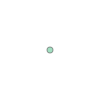

In [42]:
from shapely.geometry import Point

def get_coords(addr):
    with open("secret.txt") as f:
        key = f.read().strip()
    url = f"https://maps.googleapis.com/maps/api/geocode/json?address={addr}&key={key}"
    r = requests.get(url)
    r.raise_for_status()
    loc = r.json()["results"][0]["geometry"]["location"]
    return Point(loc["lng"], loc["lat"])
    
get_coords("2400 Block Winnebago StreetMadison, WI 53704")

In [48]:
df["geometry"] = None
for i in range(len(df)):
    addr = df.loc[i, "Address"]
    print(addr)
    coords = get_coords(addr)
    df.loc[i, "geometry"] = coords

2400 Block Winnebago StreetMadison, WI 53704
2200 Block Luann LaneMadison, WI
Lake MendotaMadison, WI
1500 Block Mayfield LaneMadison, WI
900 Block Stewart StreetMadison, WI
1100 Block E. Wilson StreetMadison, WI
John Nolen Drive & Williamson StreetMadison, WI
Interstate 90 & U.S. Highway 12Madison, WI
3300 Block University AvenueMadison, WI
I-90 Eastbound & Westbound BeltlineMadison, WI
3700 Block Morning RoadMadison, WI
Lake MendotaMadison, WI
900 Block S. Park StreetMadison, WI
3800 Block Council CrestMadison, WI
S. Stoughton Road & Buckeye RoadMadison, WI
1900 Block Atwood AvenueMadison, WI
West Towne MallMadison, WI
2200 Block Carling DriveMadison, WI
I-90 westbound (MM 139.6)Madison, WI
5100 Block Voges RoadMadison, WI
6800 Block Tottenham RoadMadison, WI
400 Block N. Few StreetMadison, WI
2400 Block Allied DriveMadison, WI 53711
Lake MendotaMadison, WI
400 Block Grand AvenueMadison, WI
900 Block Magnolia LaneMadison, WI
1000 Block N High Point RdMadison, WI
Lake MendotaMadison, 

In [50]:
type(df)

pandas.core.frame.DataFrame

In [51]:
import geopandas

In [53]:
gdf = geopandas.GeoDataFrame(df, geometry="geometry")
gdf.head()

,Incident,Date,Incident Type,Address,geometry
0,Sprinkler Extinguishes Fire in Apartment Complex,10/01/2020,Structure,"2400 Block Winnebago StreetMadison, WI 53704",POINT (-89.34906 43.09854)
1,"Kitchen Fire Displaces One, Nobody Injured",09/30/2020,Structure,"2200 Block Luann LaneMadison, WI",POINT (-89.41783 43.03289)
2,"Three Rescued, One Swims to Shore, After Canoe...",09/30/2020,Lake Rescue,"Lake MendotaMadison, WI",POINT (-89.42061 43.10967)
3,Outside House Fire Caught Quickly Thanks To Pa...,09/21/2020,Structure,"1500 Block Mayfield LaneMadison, WI",POINT (-89.37069 43.13971)
4,"Fire Totals Two Vehicles, Damages Another In A...",09/17/2020,Vehicle,"900 Block Stewart StreetMadison, WI",POINT (-89.39652 43.03004)


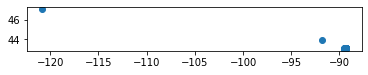

In [54]:
gdf.plot()

In [56]:
city = geopandas.read_file("zip://city.zip")

In [83]:
sep = gdf[gdf["Date"].str.startswith("09")].copy()
sep["day"] = sep["Date"].str.split("/", expand=True)[1].astype(int)
sep.head()

,Incident,Date,Incident Type,Address,geometry,day
1,"Kitchen Fire Displaces One, Nobody Injured",09/30/2020,Structure,"2200 Block Luann LaneMadison, WI",POINT (-89.41783 43.03289),30
2,"Three Rescued, One Swims to Shore, After Canoe...",09/30/2020,Lake Rescue,"Lake MendotaMadison, WI",POINT (-89.42061 43.10967),30
3,Outside House Fire Caught Quickly Thanks To Pa...,09/21/2020,Structure,"1500 Block Mayfield LaneMadison, WI",POINT (-89.37069 43.13971),21
4,"Fire Totals Two Vehicles, Damages Another In A...",09/17/2020,Vehicle,"900 Block Stewart StreetMadison, WI",POINT (-89.39652 43.03004),17
5,One Person Displaced Following Cooking Fire on...,09/17/2020,Cooking,"1100 Block E. Wilson StreetMadison, WI",POINT (-89.36697 43.08266),17


In [94]:
from IPython.core.display import HTML

fig,ax = plt.subplots()

def plot_day(day):
    ax.cla()
    city.plot(color="0.8", ax=ax)
    day_df = sep[sep["day"] == day]
    if len(day_df) > 0:
        day_df.plot(ax=ax, color="red")
    ax.set_xlim(-89.55, -89.25)
    ax.set_ylim(43, 43.175)
anim = FuncAnimation(fig, plot_day, frames=31, interval=500)
html = anim.to_html5_video()
plt.close()
HTML(html)